# Part I - NFL Big Data Bowl 2022
## by David Krejcarek

## Introduction

Before National Football League (NFL) coaches celebrate a big W, they strategize ways to improve field position and score points. Both of these objectives receive significant contributions from special teams plays, which consist of punts, kickoffs, field goals and extra points. These play types take on important roles in a game’s final score—so much so that coaches say they're a third of the game. Yet special teams remain an understudied part of American football, with an opportunity for data science to offer better ways to understand its impact.

The 2022 Big Data Bowl creates the opportunity for you (and the world!) to learn more about special teams play than ever before. We've provided the NFL's Next Gen Stats (NGS) tracking data from all 2018-2020 special teams plays. This data provides location information for each special teams player, wherever they are on the field, and includes their speed, acceleration, and direction. Additionally, and for the first time in Big Data Bowl history, participants can utilize scouting data from PFF, which supplements the tracking data with football specific metrics that coaches find critical to team success.

The NFL is America's most popular sports league. Founded in 1920, the organization behind American football has developed the model for the successful modern sports league. They're committed to advancing every aspect of the game, including the lesser researched special teams. In this competition, you’ll quantify what happens on special teams plays. You might create a new special teams metric, quantify team or individual strategies, rank players, or even something we haven’t considered.

With your creativity and analytical skills, the development of these new methods could lead to additional stats for special teams plays. If successful, your effort may even be adopted by the NFL for on air distribution, and you can watch future games knowing you had a hand in improving America's most popular sports league.

Summary of data
The 2022 Big Data Bowl data contains Next Gen Stats player tracking, play, game, player, and PFF scouting data for all 2018-2020 Special Teams plays. Here, you'll find a summary of each data set in the 2022 Data Bowl, a list of key variables to join on, and a description of each variable.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# Load three data bases
games = pd.read_csv(os.path.join('data', 'games.csv'))
players = pd.read_csv(os.path.join('data', 'players.csv'))
plays = pd.read_csv(os.path.join('data', 'plays.csv'))
pff = pd.read_csv(os.path.join('data', 'PFFScoutingData.csv'))

In [3]:

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gameId           764 non-null    int64 
 1   season           764 non-null    int64 
 2   week             764 non-null    int64 
 3   gameDate         764 non-null    object
 4   gameTimeEastern  764 non-null    object
 5   homeTeamAbbr     764 non-null    object
 6   visitorTeamAbbr  764 non-null    object
dtypes: int64(3), object(4)
memory usage: 41.9+ KB


In [4]:
# review the info of the Players
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nflId        2732 non-null   int64 
 1   height       2732 non-null   object
 2   weight       2732 non-null   int64 
 3   birthDate    2715 non-null   object
 4   collegeName  2724 non-null   object
 5   Position     2732 non-null   object
 6   displayName  2732 non-null   object
dtypes: int64(2), object(5)
memory usage: 149.5+ KB


In [5]:
# review the info of play database

plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19979 entries, 0 to 19978
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19979 non-null  int64  
 1   playId                  19979 non-null  int64  
 2   playDescription         19979 non-null  object 
 3   quarter                 19979 non-null  int64  
 4   down                    19979 non-null  int64  
 5   yardsToGo               19979 non-null  int64  
 6   possessionTeam          19979 non-null  object 
 7   specialTeamsPlayType    19979 non-null  object 
 8   specialTeamsResult      19979 non-null  object 
 9   kickerId                19878 non-null  float64
 10  returnerId              6938 non-null   object 
 11  kickBlockerId           100 non-null    float64
 12  yardlineSide            19813 non-null  object 
 13  yardlineNumber          19979 non-null  int64  
 14  gameClock               19979 non-null

In [6]:
# review the info of Games

pff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19979 entries, 0 to 19978
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   19979 non-null  int64  
 1   playId                   19979 non-null  int64  
 2   snapDetail               5919 non-null   object 
 3   snapTime                 5918 non-null   float64
 4   operationTime            5918 non-null   float64
 5   hangTime                 13098 non-null  float64
 6   kickType                 13723 non-null  object 
 7   kickDirectionIntended    13701 non-null  object 
 8   kickDirectionActual      13701 non-null  object 
 9   returnDirectionIntended  4754 non-null   object 
 10  returnDirectionActual    4756 non-null   object 
 11  missedTackler            1348 non-null   object 
 12  assistTackler            1034 non-null   object 
 13  tackler                  4759 non-null   object 
 14  kickoffReturnFormation

In [7]:
print(games.shape)
print(players.shape)
print(plays.shape)
print(pff.shape)

(764, 7)
(2732, 7)
(19979, 25)
(19979, 20)


In [22]:
# Sub the data to just the info needed
pff_sub = pff.drop(columns=['snapDetail', 
                            'snapTime', 
                            'operationTime', 
                            'missedTackler',
                            'assistTackler',
                            'tackler',                            
                            'kickoffReturnFormation',
                            'gunners',
                            'puntRushers',
                            'specialTeamsSafeties',
                            'vises',
                            'kickContactType'])     

# merge the pff data into the punt data
plays_returnable = plays_returnable.merge(pff_sub, on=['gameId', 'playId'], how='left', suffixes=()) 

# Create a sub data frrame for punt data only
punt_data = plays_returnable.query('specialTeamsPlayType == "Punt"')
punt_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5991 entries, 1 to 13830
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   5991 non-null   int64  
 1   playId                   5991 non-null   int64  
 2   playDescription          5991 non-null   object 
 3   quarter                  5991 non-null   int64  
 4   down                     5991 non-null   int64  
 5   yardsToGo                5991 non-null   int64  
 6   possessionTeam           5991 non-null   object 
 7   specialTeamsPlayType     5991 non-null   object 
 8   specialTeamsResult       5991 non-null   object 
 9   kickerId                 5917 non-null   float64
 10  returnerId               4078 non-null   object 
 11  kickBlockerId            39 non-null     float64
 12  yardlineSide             5882 non-null   object 
 13  yardlineNumber           5991 non-null   int64  
 14  gameClock              

In [8]:
# Some standard variables
BASE_COLOR = sb.color_palette()[0]

### What is the structure of your dataset?

> There are three seperate tables:
    Game data: The games.csv contains the teams playing in each game. The key variable is gameId.  This contains 764 rows with 7 columns

> Play data: The plays.csv file contains play-level information from each game. The key variables are gameId and playId. Contains a total 19,979 rows with 25 columns

> Player data: The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId. Contains 2,732 rows with 7 columns

### What is/are the main feature(s) of interest in your dataset?

> What is the best way to get a successful punt. More hang time, longer kick, kick type?  But what is a succssedful punt.  In the game of football the idea is to get into the opponents endzone or scoring position, for kicking a feild goal, and keep the opposing team out of yours.  Simple Right?  Since we are looking at the punt data we can concentrate on how to keep them out of our own endzone or scoring position.  This really mostly on the defense, how do we give the defense the best chance to stop is to push the opposing team as far away from scoring position as possible.  So a succesful punt would be defined as one that the play result would end as far away from our own endzone and scoring position.  

> Who is the best returner. As defined by the most yards per return  
> Who is the best Kicker.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Hang time:  Will want to see what the distirbution of Time is and also what hang time reults in the a Returnable ball or would require a fair catch
> Kick Length: Will want to see what the distirbution of the Kick length is and also if the distance of the kick results in a returnable ball or would require the returner to signal a fair catch
> Return Yadarge: Want to see the distribution of yards returned
> Kick Type:  Will use to see which style is the most common and if a style contributes to a longer hang time and/or longer kick.  Based on that it might be recommended to have a certain kick based on the result of the play
> Results based on Fair Catch or Return

> Determine which player is has the most return yards, most return yards per return.
> Will need to see if there is a feature that is common among the top returners.
> Will need to see if there is a difference in returns yard as a season progresses.  
> Does a specific style contrbute to the returners success or failure.

### Data Wrangling

In [9]:
# Determine which player has the most return yards
# Filter to only Kickoff and punt to determine return yards only
play_type = ['Kickoff', 'Punt']
plays_returnable = plays[plays['specialTeamsPlayType'].isin(play_type)]

# Confrim it worked
print('Values of Play Type')
print(plays_returnable.specialTeamsPlayType.value_counts())
print('Values of Play Results')
print(plays_returnable.specialTeamsResult.value_counts())

Values of Play Type
Kickoff    7843
Punt       5991
Name: specialTeamsPlayType, dtype: int64
Values of Play Results
Return                      5207
Touchback                   5156
Fair Catch                  1645
Downed                       833
Out of Bounds                650
Muffed                       214
Non-Special Teams Result      74
Blocked Punt                  39
Kickoff Team Recovery         16
Name: specialTeamsResult, dtype: int64


In [11]:
# add on the season to the dataset
plays_returnable = plays_returnable.merge(games, on = 'gameId', how='left', suffixes=())
# drop some unneeded columns
plays_returnable.drop(labels=['yardlineSide', 'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers', 'penaltyYards'], axis=1)
plays_returnable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13834 entries, 0 to 13833
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  13834 non-null  int64  
 1   playId                  13834 non-null  int64  
 2   playDescription         13834 non-null  object 
 3   quarter                 13834 non-null  int64  
 4   down                    13834 non-null  int64  
 5   yardsToGo               13834 non-null  int64  
 6   possessionTeam          13834 non-null  object 
 7   specialTeamsPlayType    13834 non-null  object 
 8   specialTeamsResult      13834 non-null  object 
 9   kickerId                13760 non-null  float64
 10  returnerId              6936 non-null   object 
 11  kickBlockerId           39 non-null     float64
 12  yardlineSide            13668 non-null  object 
 13  yardlineNumber          13834 non-null  int64  
 14  gameClock               13834 non-null

#### Split Data

Going to drop the data down to just the punt information and then drop more unneeded columns

In [25]:
# query the data to just punt inforamtion
punt_data = plays.query('specialTeamsPlayType == "Punt"')
# filter the data down further to be just return and fair catches.
punt_data = punt_data.query('specialTeamsResult == "Return" | specialTeamsResult == "Fair Catch"')
# There are no block kicker Id or pass reuslts so we can frop those two columns
punt_data.drop(columns = ['kickBlockerId', 'passResult'], inplace=True)

punt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 1 to 19972
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  3926 non-null   int64  
 1   playId                  3926 non-null   int64  
 2   playDescription         3926 non-null   object 
 3   quarter                 3926 non-null   int64  
 4   down                    3926 non-null   int64  
 5   yardsToGo               3926 non-null   int64  
 6   possessionTeam          3926 non-null   object 
 7   specialTeamsPlayType    3926 non-null   object 
 8   specialTeamsResult      3926 non-null   object 
 9   kickerId                3926 non-null   float64
 10  returnerId              3925 non-null   object 
 11  yardlineSide            3859 non-null   object 
 12  yardlineNumber          3926 non-null   int64  
 13  gameClock               3926 non-null   object 
 14  penaltyCodes            502 non-null   

In [26]:
# filter if kick return is 
punt_data[punt_data['kickReturnYardage'].isnull()].specialTeamsResult.value_counts()

Fair Catch    1640
Return           8
Name: specialTeamsResult, dtype: int64

In [27]:
pd.set_option('display.max_colwidth', None)
punt_data[punt_data['kickReturnYardage'].isnull()][punt_data['specialTeamsResult'] == 'Return']['playDescription']


C:\Users\DKREJC~1\AppData\Local\Temp/ipykernel_15888/261768806.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  punt_data[punt_data['kickReturnYardage'].isnull()][punt_data['specialTeamsResult'] == 'Return']['playDescription']


533                                                                                                                       (14:22) (Punt formation) J.Berry punts 39 yards to KC 42, Center-K.Canaday. D.Thomas to PIT 27 for 31 yards (C.Sutton). FUMBLES (C.Sutton), and recovers at PIT 22. D.Thomas to PIT 10 for 12 yards (T.Edmunds).
3850                                                                                                            (4:25) (Punt formation) R.Allen punts 49 yards to TEN 36, Center-J.Cardona. A.Jackson to TEN 49 for 13 yards (J.Develin, N.Ebner). FUMBLES (J.Develin), and recovers at NE 49. A.Jackson to NE 49 for no gain (J.Develin).
4468     (13:33) L.Cooke punts 55 yards to BUF 30, Center-M.Overton. I.McKenzie to BUF 39 for 9 yards (J.Wilson). FUMBLES (J.Wilson), and recovers at BUF 43. I.McKenzie to BUF 43 for no gain (N.DeLuca). Return credited to BUF 36 (spot of foul). PENALTY on BUF-M.Murphy, Illegal Block Above the Waist, 10 yards, enforced at BUF 36.
4597   

In [29]:
# Add zero for all the Fair Catch to be zero
punt_data.kickReturnYardage.fillna(0, inplace=True)

In [28]:
updates = [[114, 31],
           [759, 13],
           [889, 9],
           [911, -3],
           [996, 8],
           [2789, 0],
           [3191, 2],
           [3833, 6]]

for update in updates:
    punt_data.iloc[update[0], 20] = update[1]
    

In [30]:
# Confirm there are no null values left
punt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 1 to 19972
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  3926 non-null   int64  
 1   playId                  3926 non-null   int64  
 2   playDescription         3926 non-null   object 
 3   quarter                 3926 non-null   int64  
 4   down                    3926 non-null   int64  
 5   yardsToGo               3926 non-null   int64  
 6   possessionTeam          3926 non-null   object 
 7   specialTeamsPlayType    3926 non-null   object 
 8   specialTeamsResult      3926 non-null   object 
 9   kickerId                3926 non-null   float64
 10  returnerId              3925 non-null   object 
 11  yardlineSide            3859 non-null   object 
 12  yardlineNumber          3926 non-null   int64  
 13  gameClock               3926 non-null   object 
 14  penaltyCodes            502 non-null   

In [36]:

punt_data = punt_data.dropna(subset=['hangTime'])
punt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3924 entries, 0 to 3925
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   3924 non-null   int64  
 1   playId                   3924 non-null   int64  
 2   playDescription          3924 non-null   object 
 3   quarter                  3924 non-null   int64  
 4   down                     3924 non-null   int64  
 5   yardsToGo                3924 non-null   int64  
 6   possessionTeam           3924 non-null   object 
 7   specialTeamsPlayType     3924 non-null   object 
 8   specialTeamsResult       3924 non-null   object 
 9   kickerId                 3924 non-null   float64
 10  returnerId               3923 non-null   object 
 11  yardlineSide             3857 non-null   object 
 12  yardlineNumber           3924 non-null   int64  
 13  gameClock                3924 non-null   object 
 14  penaltyCodes            

Looking at the dat with can see that kickReturnYardage has quite a few null values.  There is 1640 fair catchs that have a null value which can be entered as zero yards return. A fair catch would actually result in a zero return I replaced these null values with a 0.  This woudl leave a total of 8 returnable plays that have a null values.  After reviewing the description we see that these 8 had a fumble occur which resulted in a non return.  However,  if we look at the description we can see that there was a retrun prior to fumble happening.  I used these return yards in place of the null values.  We coudl assume that if there was not fumble the most likely would have been a tackle and end to the play at about that return yards.

There was also a few hang times that are a null value.  I dropped these as the description doens't actually state anything in regards to the hang time, and there was no way to accuratly determine this value.  It made the most sense to drop these 2 rows.  

In [31]:
# Add in the game data to get season
punt_data = punt_data.merge(games, on = 'gameId', how='left')
punt_data.sample(1)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
3924,2021010315,2497,"(5:17) M.Dickson punts 52 yards to SF 22, Center-T.Ott. R.Cracraft to SF 27 for 5 yards (N.Bellore).",3,4,9,SEA,Punt,Return,46218.0,...,52.0,5.0,47,36,2020,17,01/03/2021,16:25:00,SF,SEA


In [32]:
# add in pff data to the Punt data
pff_sub = pff.loc[:,['gameId', 'playId', 'hangTime', 'kickDirectionIntended', 'kickDirectionActual', 'returnDirectionIntended', 'returnDirectionActual', 'kickType']]

# merge into punt_data
punt_data = pd.merge(punt_data, pff_sub, on=['gameId', 'playId'])

punt_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 0 to 3925
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   3926 non-null   int64  
 1   playId                   3926 non-null   int64  
 2   playDescription          3926 non-null   object 
 3   quarter                  3926 non-null   int64  
 4   down                     3926 non-null   int64  
 5   yardsToGo                3926 non-null   int64  
 6   possessionTeam           3926 non-null   object 
 7   specialTeamsPlayType     3926 non-null   object 
 8   specialTeamsResult       3926 non-null   object 
 9   kickerId                 3926 non-null   float64
 10  returnerId               3925 non-null   object 
 11  yardlineSide             3859 non-null   object 
 12  yardlineNumber           3926 non-null   int64  
 13  gameClock                3926 non-null   object 
 14  penaltyCodes            



First let see the if the kick lenth has any correlation with the return length.  Since these are both qualitative continous using a scatterplot would be the most appriate 

The most used is Normal kick type, followed byt Aussie_Style Kick type.  There are a few that use Rugby style but the numer is 

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


### Punt Results

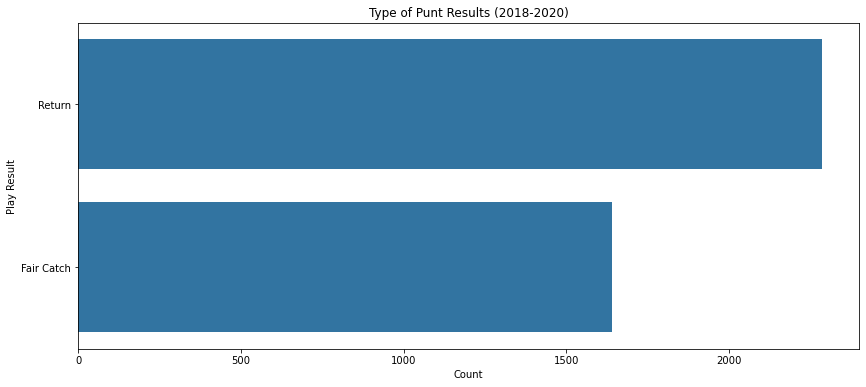

In [154]:
# Display the results of these kicks, this is a categorical element so a bar chart would be appropiate
plt.figure(figsize=[14,6])
sb.countplot(y =punt_data['specialTeamsResult'], color=BASE_COLOR, order=punt_data.specialTeamsResult.value_counts().index)
plt.title('Type of Punt Results (2018-2020)')
plt.ylabel('Play Result')
plt.xlabel('Count');

The intial review of the the play type results of kickpff and returns shows that the majority of the Results appears to be a return followed by a touchback.  This would be an interesting to see of this has changed over the course of the seasons.  And also what the diffence is between kick off and punts

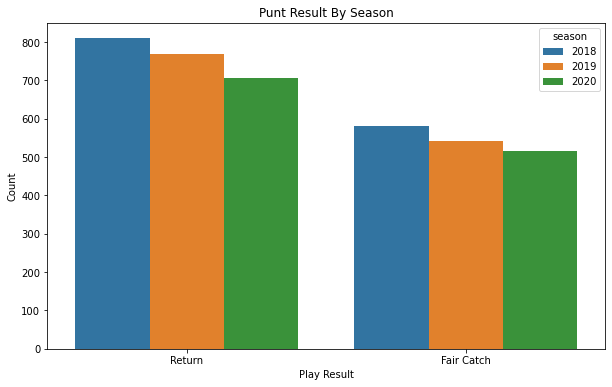

In [166]:
# Display the play results based on the season (Row) and also on the type (col)
order = punt_data.specialTeamsResult.value_counts().index
# increase the size of plot
plt.figure(figsize=[10,6])

# A box plot becacuse specialteam results is a category
sb.countplot(data = punt_data, x='specialTeamsResult', hue='season', order = order)
plt.title('Punt Result By Season')
plt.xlabel('Play Result')
plt.ylabel('Count');

When can see that using the two returnable type of kicks, kickoffs and punts, we can see that most lickely result will be a touch back followed by a return.  While a punt the most likely response will be a return followed by a fair catch.  We can also see by this data that it looks like the this breakdown is consistant over the course of the last three season.  

### Punt Length

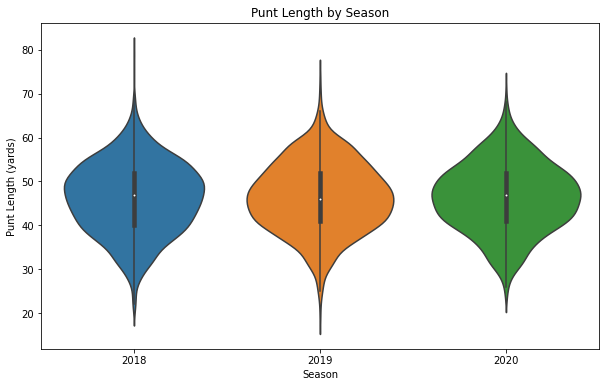

In [168]:
# g = sb.FacetGrid(data = plays_returnable, col = 'specialTeamsPlayType', row = 'season', aspect=1.5)
# g.map(sb.violinplot, 'kickLength', order= ['2018', '2019', '2020']);
plt.figure(figsize=[10,6])

sb.violinplot(data = punt_data, x = 'season', y = 'kickLength')
plt.title('Punt Length by Season')
plt.xlabel('Season')
plt.ylabel('Punt Length (yards)';

Plotting the punt length over teh course of the seasons from 2018 to 2020, we see that there was consitancey over the course of the season.  THe meadian of all three season was just under 50 yards.  The distribution also seems similar when we look at this.  

### Punt Return Yards

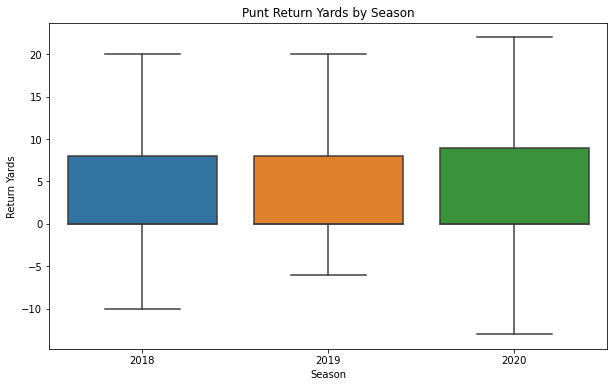

In [186]:
# Make the plot slightly bigger to match the other plot sizes
plt.figure(figsize=[10,6])

sb.boxplot(data = punt_data, x = 'season', y = 'kickReturnYardage', showfliers = False)
plt.title('Punt Return Yards by Season')
plt.xlabel('Season')
plt.ylabel('Return Yards');

Reviewing the Return yards over the course of the last three seasons there appears to be a consistancy through each season.  Although 2020 does display a slightly larger spread from 0 yard return to just under 10 yards the other season are with a yard or two of the spread.  

Lets check on which player has the most returns and the most yards

In [15]:
# Get the names of the players
# Get names for labels

def name_labels(df, year):
    ''' Returns a list of names to use as axis labels '''
    top_ten_returners = plays_returnable.query('season == {}'.format(year)).returnerId.value_counts()[:10]

    new_labels = []
    for i in top_ten_returners.index:
        name = df[df['nflId'] == int(i)]['displayName'].values[0]
        new_labels.append(name)
    
    return new_labels



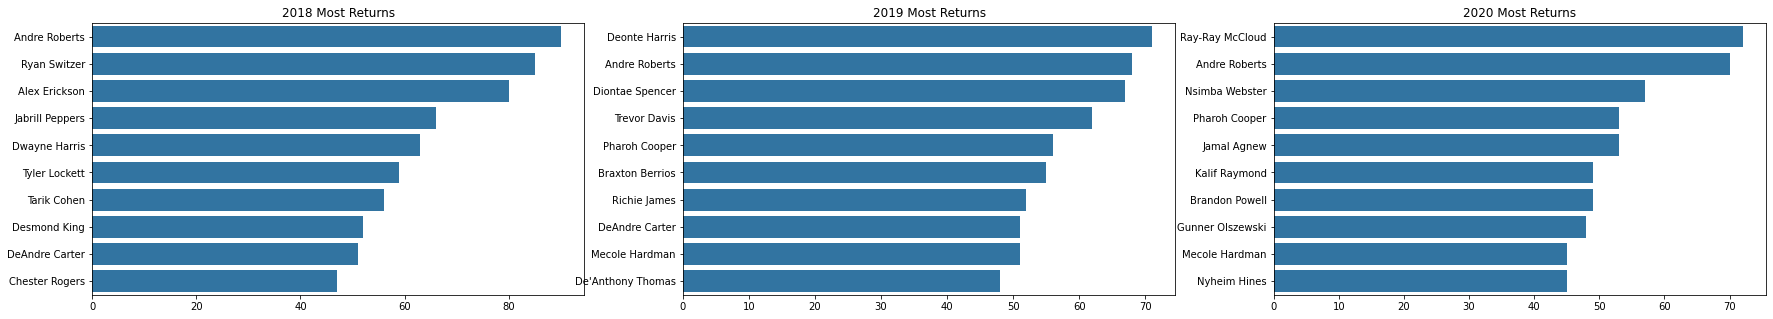

In [16]:
# Split the data into indivudual seasons
plt.figure(figsize=[30, 5])

# Plot the 2018 Season
plt.subplot(1, 3, 1)
plt.title('2018 Most Returns')
top_ten_returners_2018 =  plays_returnable.query('season == 2018').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2018.index, x = top_ten_returners_2018.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2018))

# Plot the 2019 Season
plt.subplot(1, 3, 2)
plt.title('2019 Most Returns')
top_ten_returners_2019 =  plays_returnable.query('season == 2019').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2019.index, x = top_ten_returners_2019.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2019))

# Plot the 2020 Season
plt.subplot(1, 3, 3)
plt.title('2020 Most Returns')
top_ten_returners_2020 =  plays_returnable.query('season == 2020').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2020.index, x = top_ten_returners_2020.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2020));

When we review the top ten returners over the 2018 thru 2020 season we can see that Andre Roberts was consistantly in the top two year over year in returns.  Being the bes tin 2018 and being second in the 2019 and 2020.  One intersesting to note that in 2018 the top three players all had over 80 reutrns, while int he next two years the max number of reutnrns was only in the low 70's.  Even though previosuly we showed that there wasn't an significant difference in the over all number of returnable kicks.  This is just the number of oppurtunities that a kick receiver had to return a kick.  The next item will be to see who has the most return yards and who has the most yards per return.

Total number of total return yards.  

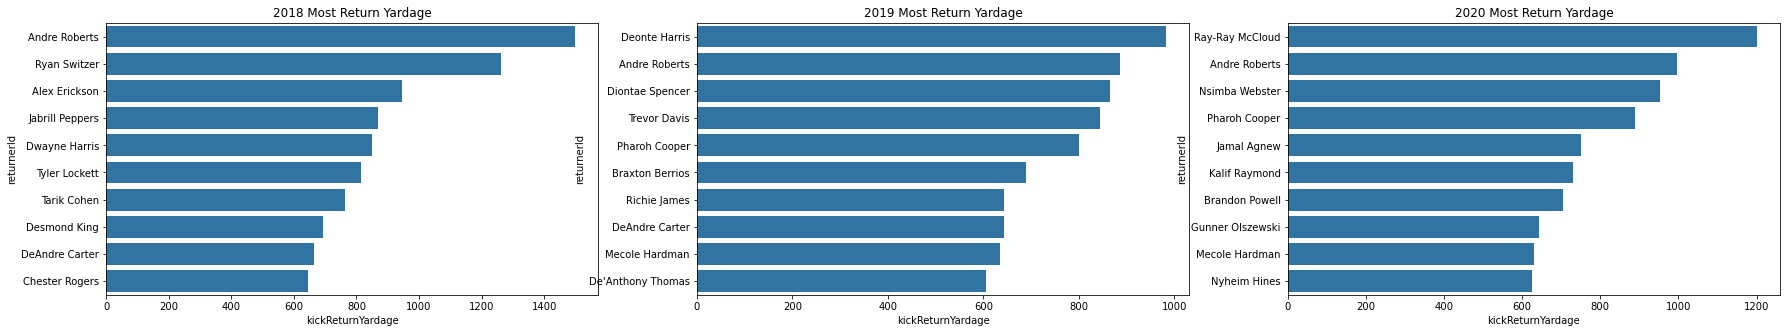

In [17]:
# Create a 3 wide bar plot of the top ten returners by yaradge
# Create a wide plot figure
plt.figure(figsize=[30,5])

seasons = [2018, 2019, 2020]  # TODO: Update this to be the index
plot = 1

for season in seasons: 
    plt.subplot(1, 3, plot)
    plot += 1 # moves the plot over one
    data = plays_returnable.query('season == {}'.format(season)).groupby('returnerId').sum().sort_values(by=['kickReturnYardage'], ascending=False)[:10]
    sb.barplot(y = data.index, x = data.kickReturnYardage, color=BASE_COLOR)
    plt.title('{} Most Return Yardage'.format(season))
    plt.yticks(np.arange(10), name_labels(players, season))
    


The top ten returners doesn't seem to change when looking at total yards instead of looking at the number of returns.  

Check to see if there is a difference in the yards oer return

In [18]:
# Determine the yards per return average by season
def get_season_data(season):
    # Get the data for number of return counts
    punt_return_counts = plays_returnable.query('season == {} & specialTeamsPlayType == "Punt"'.format(season)).returnerId.value_counts()
    kickoff_return_counts = plays_returnable.query('season == {} & specialTeamsPlayType == "Kickoff"'.format(season)).returnerId.value_counts()
    # get the the series for the total yards
    punt_return_yards = plays_returnable.query('season ==  {} & specialTeamsPlayType == "Punt"'.format(season)).groupby('returnerId').sum()['kickReturnYardage']
    kickoff_return_yards = plays_returnable.query('season == {} & specialTeamsPlayType == "Kickoff"'.format(season)).groupby('returnerId').sum()['kickReturnYardage']
    # Create a dictionary for concatations
    data = {'punt_return_yards': punt_return_yards,
            'punt_return_counts': punt_return_counts,
            'kickoff_return_yards': kickoff_return_yards,
            'kickoff_return_counts': kickoff_return_counts}

    # Concat the two series into new datafra,e
    returner_data = pd.concat(data, axis=1) 

    # determine the yards per return
    returner_data['punt_yard_per_return'] = returner_data['punt_return_yards'] / returner_data['punt_return_counts']
    returner_data['kickoff_yard_per_return'] = returner_data['kickoff_return_yards'] / returner_data['kickoff_return_counts']

    return returner_data

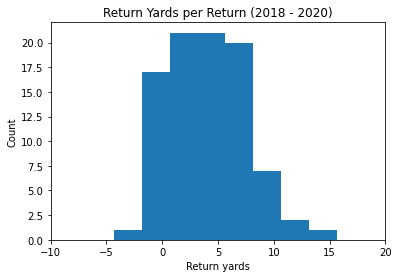

In [196]:
x_bins = np.arange(returner_data['punt_yard_per_return'].min(), returner_data['punt_yard_per_return'].max()+2.5, 2.5)

plt.hist(returner_data['punt_yard_per_return'], bins=x_bins)
plt.title('Return Yards per Return (2018 - 2020)')
plt.xlabel('Return yards')
plt.ylabel('Count')
plt.xlim(-10, 20);

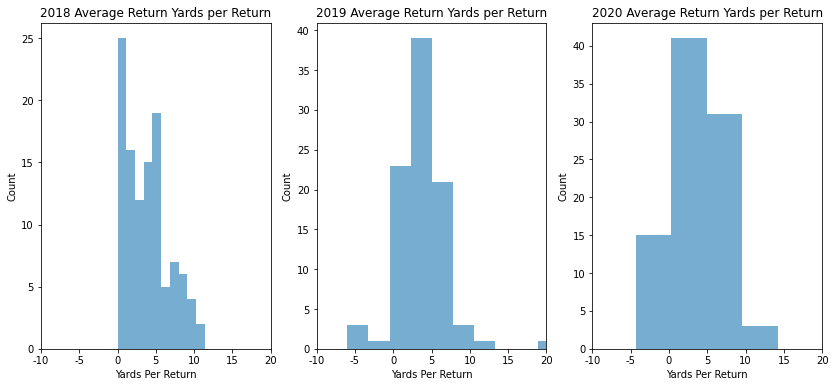

In [193]:

seasons = [2018, 2019, 2020]
plot_no = 1

plt.figure(figsize=[14,6])
for season in seasons:
    plt.subplot(1, 3, plot_no)
    plot_no += 1
    returner_data = get_season_data(season)
    plt.hist(returner_data['punt_yard_per_return'], alpha = .6, label='Punt')
    plt.title('{} Average Return Yards per Return'.format(season))
    plt.xticks(np.arange(-10, 20 + 5, 5), np.arange(-10, 20 + 5, 5)) 
    plt.xlim(-10, 20)
    plt.xlabel('Yards Per Return')
    plt.ylabel('Count');

I first looked at the yards per return as a whole and looking at that distribution of the yard per return avergae it appears that there are two seperate peaks one at 5 yards and the at around 20 yards.  These two parts I beleive would be based on punt verus kickoff returns.  With that it made more sense that the data should seperated by kickoff and punts values so that it can be shown that there is a differnce.  

After adjusting the data to display the distribution of yards per return, we can see that there are indeed two sepearate peaks which coresonding to the punt and kickoff.  A kickoff return has a higher average per carry but it also is skewed to the left.  This makes perfect sense based on that typically a kickoff is a longer kick and has more room to return.  It is intresting to see that a touch back would give the returning team a starting ball positon of 25.  It would interesting to see what the starting yard line for kickoffs is and if there is even a benefit of returning a ball.  It could make sense for a team to never return a kickoff and always try to take a touchback.  There might also be a benefit for a kicking team to not kick the ball into the endzone and force a return to push the starting kickoff behind the 25 yardline.  

There is still two peaks in the punting for 2018, this would be makes sense that the top two results was Return or a Fair Catch.  The Fair catch would push the average down around zero and then a return it would appear that the average is 5 yards.  There is some room in this area to further dive into the this data and see of what factors of a kick contribute to a a fair catch versus a good retrun. It would appear that for years 2019 and 2020 the punt does not have a two distinct peaks but actually follows a more normal distribution.  But this isn't the same case as with  

### Punt Hang Time Review

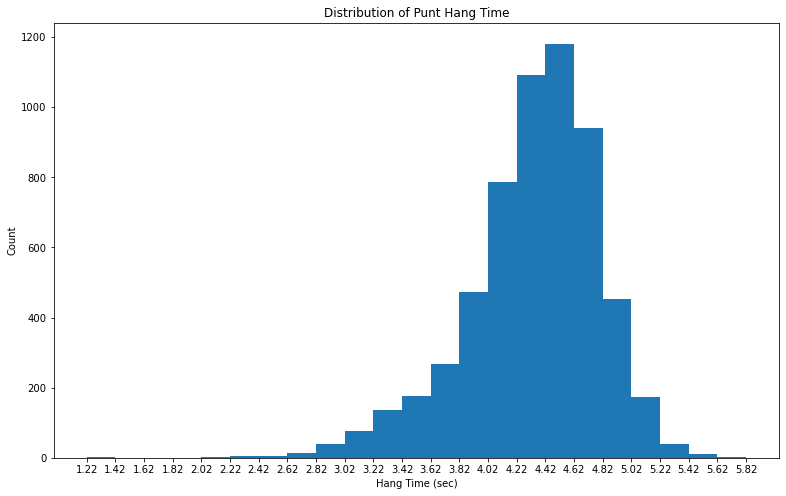

In [23]:
plt.figure(figsize=[13,8])
bins = np.arange(punt_data.hangTime.min(), punt_data.hangTime.max() + .2, .2)

plt.hist(punt_data.hangTime, bins=bins) 
plt.title('Distribution of Punt Hang Time')
plt.xticks(bins)
plt.xlabel('Hang Time (sec)')
plt.ylabel('Count');

Looking at the hang time is normally distrubuted 4.22 sec. The median hang time is between 4.02 and 4.22 sec.  The times appear to be distructuted nramlly with a slight skew to the left this seen by the long tail on the left but this is only a slight skew of the data.  

#### Punt Style Review

There are a total of 3 types of kicks used Normal, Aussie-Style, Rugby Style.  Lets see what the use of these three types are.  

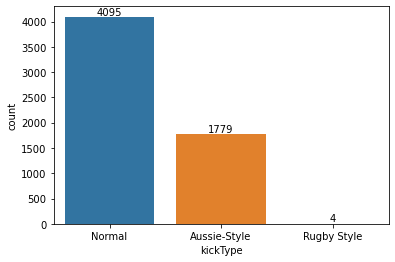

In [24]:
# Plot the bar plot for the kick type
kick_styles = {'N': 'Normal',
               'A': 'Aussie-Style',
               'R': 'Rugby Style'}
# determine new tick values 
n_kicks = punt_data['kickType'].value_counts().sum()
x_counts = punt_data.kickType.value_counts()
x_values = list(x_counts.index)
x_labels = []
for x in x_values:
    x_labels.append('{}'.format(kick_styles[x]))

# Plot the count of styles
chart = sb.countplot(data=punt_data, x='kickType', order=x_values)
chart.bar_label(chart.containers[0])

plt.xticks(range(0, len(x_values)), x_labels);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Kick Length Versus Return Yards

<Figure size 1008x360 with 0 Axes>

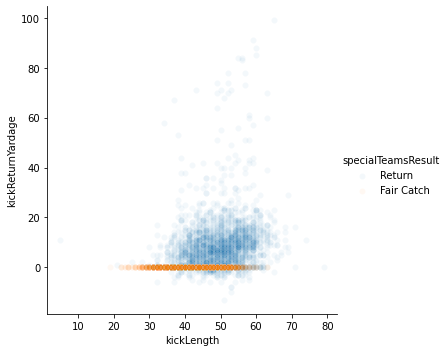

In [33]:
plt.figure(figsize=[14,5]);
g = sb.FacetGrid(punt_data, hue = 'specialTeamsResult', height=5, aspect=1)
g.map(sb.scatterplot, 'kickLength', 'kickReturnYardage', alpha = .05)
g.add_legend();


There doesn't seem to be any strong coorelation between the length of a punt as a whole, we should look at this data from a season to season to see if that reduction of data pionts can help see of there is an clustering patterns.  

<Figure size 1008x360 with 0 Axes>

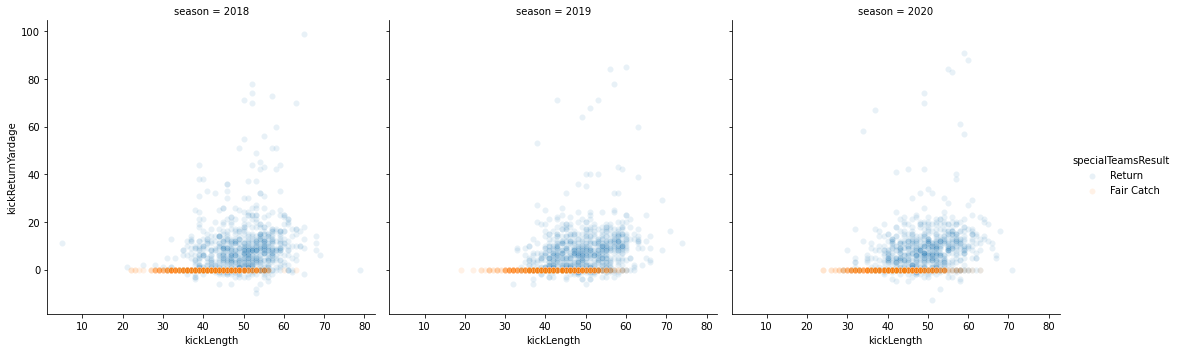

In [34]:
plt.figure(figsize=[14,5])
g = sb.FacetGrid(punt_data, col = 'season', hue = 'specialTeamsResult', height=5, aspect = 1)
g.map(sb.scatterplot, 'kickLength', 'kickReturnYardage',  alpha = .1)
g.add_legend();

There doesn't appear to be any correlation between the kick length and kick return.  It does look like that if there is a kick that is less than 35 yards there are few if any returns.  While any of punt that is less than 35 yards appears to be mostly ends in a fair catch.  But since there is no actual correlation between that and the return we will need to turn towards the hang time and see if there is a better correlation between that and the return length.  

The first step is that I will need to add on the pff data

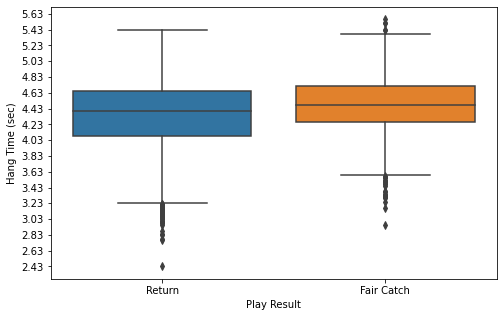

In [35]:
# Plot the hangtime versus the count of 
# make the hangtime down to the a 1/4 sec
x_label = np.arange(punt_data['hangTime'].min(), punt_data['hangTime'].max()+.2, .2)

plt.figure(figsize=[8, 5])

sb.boxplot(data = punt_data, x = 'specialTeamsResult', y='hangTime')
plt.yticks(x_label)
plt.ylabel('Hang Time (sec)')
plt.xlabel('Play Result');
   

There is a slight difference in the play result versus hang time.  It would appeat that if the hang time is above 4.43 seconds that the chances of return are diminshed, with most returns are under 4.63 seconds.  The return also appears to be slightly skewed to the left.  This would make sinse since the hang time   

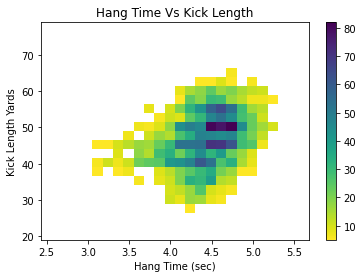

In [37]:
# plot to see if there is a corelation between hang time and kick length
x_bins = np.arange(punt_data.hangTime.min(), punt_data['hangTime'].max() + 0.125, 0.125)
y_bins = np.arange(punt_data.kickLength.min(), punt_data.kickLength.max() + 2.5, 2.5)


plt.hist2d(data = punt_data, x = 'hangTime', y='kickLength', cmin=5, cmap='viridis_r', bins=[x_bins, y_bins])
plt.colorbar()
plt.title('Hang Time Vs Kick Length')
plt.xlabel('Hang Time (sec)')
plt.ylabel('Kick Length Yards');


Beacuse the data points of this data set is pretty large, a heatmap would make a better choice to see any patterns.  We can see that the majority of kicks had a hang time arounf the 4.5 sec, resulting in a kick length of 50 yards or so.  WE can now take a look and see if there is a pattern with the hang time and kick length have an affect on the whether the punt will result in a fair catch or a return.  

Lets take a look at which type of kick produces the best hang time and the best the kick length

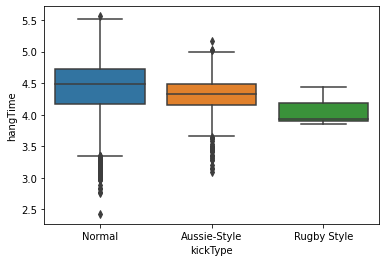

In [45]:
# Plot the bar plot for the kick type
kick_styles = {'N': 'Normal',
               'A': 'Aussie-Style',
               'R': 'Rugby Style'}
# determine new tick values 
x_order = list(x_counts.index)
x_labels = []
for x in x_order:
    x_labels.append('{}'.format(kick_styles[x]))
    
sb.boxplot(data = punt_data, x = 'kickType', y = 'hangTime', order=x_order)
plt.xticks(range(0, len(x_order)), x_labels);

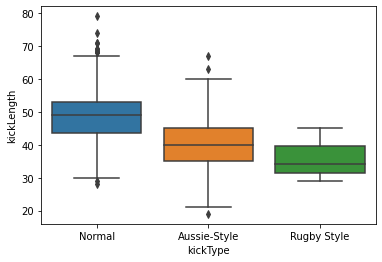

In [46]:
sb.boxplot(data=punt_data, x = 'kickType', y = 'kickLength', order = x_order)
plt.xticks(range(0, len(x_order)), x_labels);

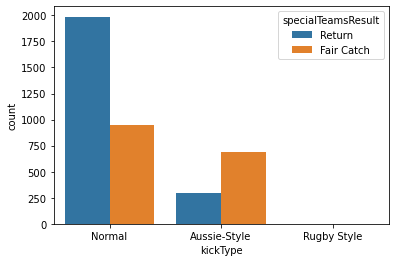

In [59]:
sb.countplot(data=punt_data, x = 'kickType', hue = 'specialTeamsResult')
plt.xticks(range(0, len(x_order)), x_labels);

From these two graphs we can see that Normal punt type has the highest Hang Time and also the longest kick.  The hang time for the Aussie stye is only slightly less then the hang time of Normal.  However, we can see that the Aussie style doesn't get the same kick length.  The Rigby style is by far the worse form of kicking with the Hang time being almost 1/2 sec less then Normal Style and even worse the average is about 10 yards shorter. I would recommend staying away from that style.  

One important note is that the Aussie Style Type actaully produces a significant more Fair Catches then returns.  Again the woudl sacarfice kick yards 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

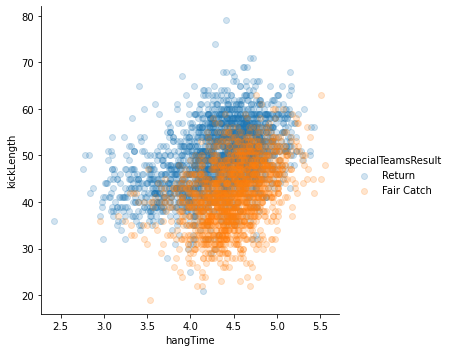

In [69]:
g = sb.FacetGrid(data = punt_data, hue = 'specialTeamsResult', height=5, aspect = 1)
g.map(plt.scatter, 'hangTime', 'kickLength', alpha = 0.2)
g.add_legend();

We can see that there does seem to be a two clusters based on the hang time and kick length.  It is hard to really see what is happending so lets switch from a scatter plot to a heat map to see where the center of the two clusters are.

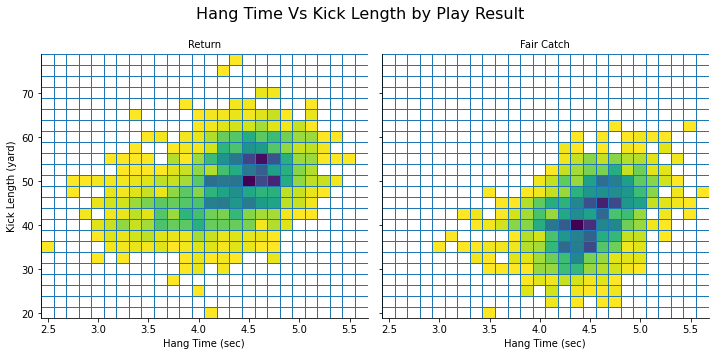

In [90]:
# plot the hang time versus kick length split among Return and Fair Catch.  With the amoutn of data two seperate heat maps would make more since
g = sb.FacetGrid(data = punt_data, col = 'specialTeamsResult', height=5, aspect = 1)
g.map(plt.hist2d, 'hangTime', 'kickLength', cmin=.5, cmap='viridis_r', bins = [x_bins, y_bins])
g.fig.subplots_adjust(top  = 0.85)
g.fig.suptitle('Hang Time Vs Kick Length by Play Result', fontsize=16)
g.set_titles("{col_name}") # use this argument literally
g.set_axis_labels('Hang Time (sec)', 'Kick Length (yard)')
g.add_legend();

In [40]:
total = punt_data.shape[0]
count = punt_data[punt_data['kickReturnYardage'] < 10].playId.count()

print(count / total)

0.7861875637104995


Splitting the data into the results of Return or Fair catch we can see that although the Hang time of the kicks for both Return and Fair Catches was about 4.5 sec the Fair catch could might be slightly.  The kick length shows a different story.  Although the hang time is similar we can see that the kick length changes, with a hang time of arounf 4.5 second and a about 50 yard to 55 yard, has a higher chance to be returned.  While a kick length of 40 to 45 yards has a higher chance of being downed as a fair catch.  If the goal would be to not have a return then the recommendation would be for punter to shoot for a high short kick.  This makes sense because this gives the gunners the best oppurtunity to get into position to force a Fair Catch call.  

One concern would be you are giving the opposing team about 10 yards by kicking it short.  Is this going to give the opposing team better field position.  As we showed earlier that the average return is usually between 2.5 and 7.5 yards and 78% of all returns are under 10 yards which would be less than or equal to having the punter kick the punt short.   At this point the recommendation would be for the punter to have a hang time og apprx 4.5 sec and get the ball within the 50 - 55 yard range.  This sets the team up with the highest chance of success.  Which would be difined as the opposing team have field position furthest from the endzone.  

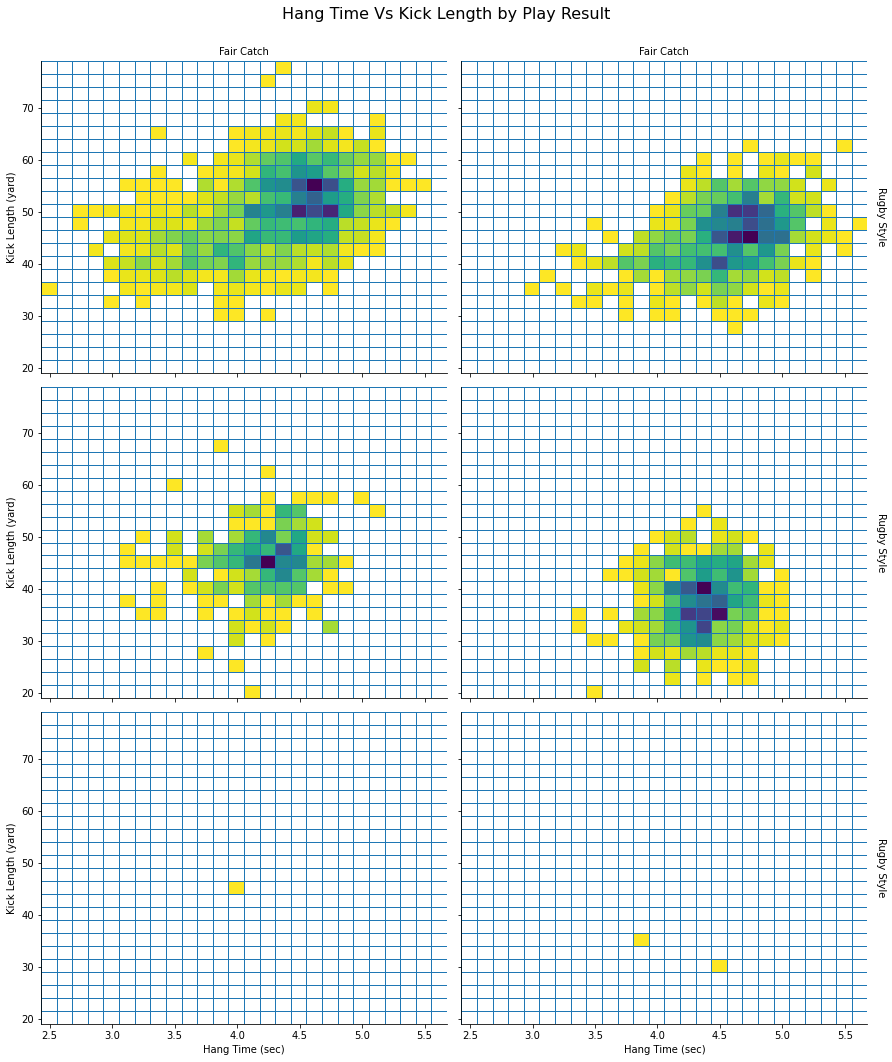

In [150]:
x_bins = np.arange(punt_data.hangTime.min(), punt_data['hangTime'].max() + 0.125, 0.125)
y_bins = np.arange(punt_data.kickLength.min(), punt_data.kickLength.max() + 2.5, 2.5)

kick_styles = {'N': 'Normal',
               'A': 'Aussie-Style',
               'R': 'Rugby Style'}

g = sb.FacetGrid(data = punt_data, row = 'kickType', col = 'specialTeamsResult', margin_titles=True, height =5, aspect = 1.25)
g.map(plt.hist2d, 'hangTime', 'kickLength', cmin=.5, cmap='viridis_r', bins = [x_bins, y_bins])
g.fig.subplots_adjust(top  = .93)
g.fig.suptitle('Hang Time Vs Kick Length by Play Result', fontsize=16)
for (row_val, col_val), ax in g.axes_dict.items():
    g.set_titles(col_template = "{}".format(col_val), row_template = "{}".format(kick_styles[row_val]))

# g.set_titles("{col_name}", '{}'.format(kick_styles[row_name])) # use this argument literally
g.set_axis_labels('Hang Time (sec)', 'Kick Length (yard)');

With this information we should really come up with a game plan for which Returner 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

